## Modules à importer

In [8]:
import math
import scipy
import pickle
import sncosmo
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
#from variaIa import baserate
#from variaIa import stretchevol
from scipy.stats import poisson
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
import random

## Définitions et sélection de l'échantillon à utiliser

In [2]:
d = pd.read_csv('../../../../Data/sne/data_cheat.csv', sep=' ', index_col='CID')
d_snf = pd.read_csv('../../../../Data/sne/lssfr_paper_full_sntable.csv', sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value='PS1')

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])],
        'survey_all': d[d['IDSURVEY'].isin([1, 15, 4])]}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

# Détermination des $z_{\text{max}}$ _via_ SNcosmo

#### For every (x1, c) in an ([-3, 3], [-0.3, 0.3]) ellipse, we want to find the absolute magnitude 5 days prior to the peak value taken at -19.36: M is indeed a function of (x1, c, t).

#### We set the SN near z=0, with c and x1 to 0 for that is the value that will give the actual peak absolute magnitude, and then we get M by taking the apparent magnitude it has, minus the distance modulus.

In [36]:
M_list = []
model = sncosmo.Model("salt2")
model.set(z=0.00000001, t0=55000, c=0., x1=0)
model.set_source_peakabsmag(-19.36, "bessellb", "ab", cosmo=Planck15)

a=3.     #radius on the x-axis
b=.3    #radius on the y-axis
t = np.linspace(0, 2*np.pi, 10000)

data = dict()

for i in range(len(t)):
    data[i] = {'c': b*np.sin(t)[i],
               'x1': a*np.cos(t)[i]}
    model.update(data[i])
    data[i]['M'] = model.bandmag('bessellb', 'ab', model["t0"]-5)\
                 - Planck15.distmod(model["z"]).value

df = pd.DataFrame(data).T

#### The effective instrinsec magnitude also depends linearly on (x1, c) according to the Tripp equation, and as such we correct for that.
#### α is taken at 0.156, and β at 3.14 according to Scolnic 2018a, table 7

In [37]:
df['M_eff'] = df['M']-0.158*df['x1']+3.14*df['c']

#### Find the values for the lowest effective absolute magnitude 5 days prior

In [38]:
df.sort_values('M_eff', ascending=False).iloc[0]

c         0.249980
x1       -1.658620
M       -19.127105
M_eff   -18.080107
Name: 3432, dtype: float64

#### Compare to the values of M, M_eff at peak

In [21]:
p = model.bandmag('bessellb', 'ab', model["t0"])- Planck15.distmod(model["z"]).value
p2 = p -0.158*-1.66 + 3.14*0.25
print(p, p2)

-19.35684909918463 -18.30956909918463


## Plotting the results

Text(0.82, -0.4, '$z = 1.50$')

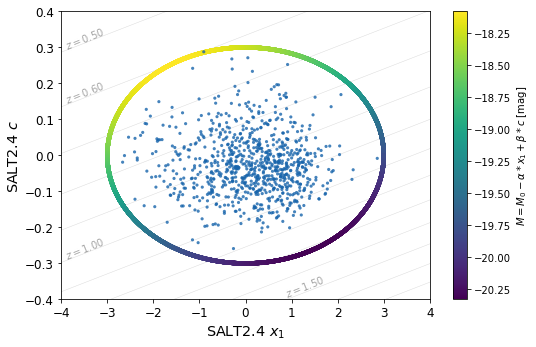

In [9]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ts = ax.scatter(df['x1'],
                df['c'],
                marker='o',
                cmap='viridis',
                c=df['M_eff'], edgecolors="None",
                s=20,
                zorder=2)

cl = fig.colorbar(ts, label=r'$M = M_0-\alpha*x_1 + \beta*c$ [mag]')

#ax.hist2d(surv['survey_all'].x1,
#          surv['survey_all'].c,
#          range=[[-4, 4], [-.4, .4]],
#          bins=20,
#          cmap=plt.cm.binary,
#          vmin=1,
#          alpha=.8)

ax.scatter(surv['survey_all'].x1,
           surv['survey_all'].c,
           marker='.',
           fc=plt.cm.Blues(.8, .8),
           edgecolors="None",
           lw=.5,
           s=40,
           zorder=2)

ax.tick_params(labelsize=12)

ax.set_xlabel(r'SALT2.4 $x_1$', fontsize='x-large')
ax.set_ylabel(r'SALT2.4 $c$', fontsize='x-large')

ax.set_xlim(-4, 4)
ax.set_ylim(-.4, .4)

fig.savefig('../../../../Images/zmax_maglim_all.pdf', bbox_inches='tight')

#ax.scatter(df.sort_values('M_eff', ascending=False).iloc[0]['x1'],
#           df.sort_values('M_eff', ascending=False).iloc[0]['c'],
#           color='k',
#           marker='+', s=100, zorder=8)

m_lim = 24.8
M_min = -19.05
x = np.linspace(-4, 4, 4000)
z = 0.5
prop=dict(zorder=1, alpha=.2, color='0.3', lw=0.5, ls='-')

for z_show in np.linspace(0.5, 2, 16):
    c = (m_lim - M_min + 0.156*x - Planck15.distmod(z_show).value)/3.14
    ax.plot(x, c, **prop)

text_prop=dict(rotation=22, ha='left', va='bottom', color='0.3', alpha=0.5)

ax.text(-3.95, 0.29, r'$z = 0.50$', **text_prop)
ax.text(-3.95, 0.14, r'$z = 0.60$', **text_prop)
#ax.text(1.3, 0.29, r'$z = 0.70$', rotation=22, fontsize='large')
#ax.text(2.25, 0.22, r'$z = 0.80$', rotation=22, fontsize='large')
#ax.text(2.78, 0.14, r'$z = 0.90$', rotation=22, fontsize='large')
ax.text(-3.95, -0.295, r'$z = 1.00$', **text_prop)
#ax.text(2.97, -0.090, r'$z = 1.20$', rotation=22, fontsize='large')
#ax.text(2.97, -0.230, r'$z = 1.40$', rotation=22, fontsize='large')
ax.text(0.82, -0.4, r'$z = 1.50$', **text_prop)

#fig.savefig('../../../../Images/pdf/zmax_maglim_snls.pdf', bbox_inches='tight')

#### Define a function returning the value of z minimizing the difference in distance modulus, which we get as the difference between the m_lim and M_lim

In [10]:
def find_zmax(mag_lim, magabs_lim=-18.00):
    return(find_z(mag_lim - magabs_lim))

def find_z(distmod, cosmo=None):
    if cosmo is None:
        from astropy.cosmology import Planck15
        cosmo = Planck15
    return(scipy.optimize.fmin(lambda z:np.abs(cosmo.distmod(z).value - distmod), 0.1, disp=0))

In [14]:
find_zmax(20.5, -18.85)

array([0.15095703])

#### Actually compute it for the m_lim of PS1, SDSS and SNLS found in articles

In [42]:
m_lim = {'SDSS': 20.5,   # Dilday 2008 page 9, g band and computing the 5\s from 3.5\s
         'PS1': 23.1,    # Rest 2014 table 2, g band
         'SNLS': 24.8}   # CFHTLS i band

In [46]:
z_max_ml = dict()
z_lim_cons = [.15, .27, .55]

i = 0

for survey in list(m_lim.keys()):
    z_max_ml[survey] = [z_lim_cons[i], find_zmax(m_lim[survey])[0]]
    i += 1
    
#z_max_ml['SDSS'][-1] = 0.2    # La littérature dit qu'il faut prendre ça
z_max_ml

{'SDSS': [0.15, 0.10508789062500001],
 'PS1': [0.27, 0.3094531250000007],
 'SNLS': [0.55, 0.5994531250000017]}

In [19]:
with open('../Data/zmax_mlim', 'wb') as f:
    pickle.dump(z_max_ml, f)

#### Comparison with z_max found with the statistical approach

In [20]:
with open('../Data/zmax_spec_result', 'rb') as f:
    z_lins, meds, stds, z_max, itsc = pickle.load(f)

z_max

{'SDSS': [0.1728, 0.2039, 0.2301],
 'PS1': [0.1821, 0.2732, 0.3568],
 'SNLS': [0.5937, 0.6162, 0.6565]}